In [120]:
import os
import numpy 
from scipy import integrate, linalg 
from matplotlib import pyplot

%matplotlib inline

# Part 1: Williams' test case

In [121]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [122]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians
        
        

def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]



def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A



def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A




def kutta_condition(A_source, B_vortex, N):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b=numpy.empty((2,A_source.shape[1]+2), dtype=float)
    
    #N = len(A_source)/2
    
    b[0,:-2]=B_vortex[0,:]+B_vortex[N-1,:]
    b[1,:-2]=B_vortex[N,:]+B_vortex[2*N-1,:]
    
    b[-2,-2]=-numpy.sum(A_source[0,:N-1]+A_source[N-1,:N-1])
    b[-2,-1]=-numpy.sum(A_source[0,N:]+A_source[N-1,N:])
    b[-1,-2]=-numpy.sum(A_source[N,:N-1]+A_source[2*N-1,:N-1])
    b[-1,-1]=-numpy.sum(A_source[N,N:]+A_source[2*N-1,N:])
    return b


def build_singularity_matrix(A_source, B_vortex, N):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = numpy.zeros((A_source.shape[0]+2, A_source.shape[1]+2), dtype=float)
    
    #N = len(A_source)/2
    
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = numpy.sum(B_vortex[:,:N-1], axis=1)
    A[:-2, -1] = numpy.sum(B_vortex[:,N:], axis=1)
    # Kutta condition array
    A[-2:, :] = kutta_condition(A_source, B_vortex, N)    
    return A



def build_freestream_rhs(panels, freestream, N):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    
    #N = len(panels)/2
    
    b = numpy.empty(panels.size+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition on main airfoil
    b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                              +numpy.sin(freestream.alpha-panels[N-1].beta) )
    # freestream contribution on the Kutta condition on flap
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[(N)].beta)
                              +numpy.sin(freestream.alpha-panels[2*N-1].beta) )
    return b



def compute_tangential_velocity(panels, freestream, gamma_1, gamma_2, A_source, B_vortex, N):
    """Computes the tangential velocity on the surface.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    gamma -- circulation density.
    """
    
    #N = len(panels)/2
    
    strength = numpy.append([panel.sigma for panel in panels],gamma_1)
    strength = numpy.append(strength,gamma_2)
    A = numpy.empty((panels.size,panels.size+2), dtype=float)
    A[:,:-2]=B_vortex
    A[:,-2]=-numpy.sum(A_source[:,:N-1],axis=1)
    A[:,-1]=-numpy.sum(A_source[:,N:],axis=1)    
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    vt = numpy.dot(A, strength) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

        
        
        
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [123]:
def load_data(add_a,add_b):
    Wing = numpy.genfromtxt(add_a, delimiter =',')
    Flap = numpy.genfromtxt(add_b, delimiter = ',')
    
    Wing_x, Wing_y = Wing[:,0], Wing[:,1]
    Flap_x, Flap_y = Flap[:,0], Flap[:,1]
    
    return Wing_x, Wing_y,Flap_x, Flap_y

In [124]:
def panelize(Wing_x, Wing_y,Flap_x, Flap_y):
    
    
    N = numpy.size(Wing_x)-1
    Wing_panels = numpy.empty(N, dtype = object)
    Flap_panels = numpy.empty(N, dtype = object)
    for i in range(N):
        Wing_panels[i] = Panel(Wing_x[i],Wing_y[i],Wing_x[i+1],Wing_y[i+1])
        Flap_panels[i] = Panel(Flap_x[i],Flap_y[i],Flap_x[i+1],Flap_y[i+1])
   
    
    return  Wing_panels,Flap_panels, N

In [125]:
def plot_section(Wing_panels,Flap_panels, Wing_x, Wing_y,Flap_x, Flap_y):
    
    N = numpy.size(Wing_x)-1
    width= 15 
    pyplot.figure(figsize=(width,width))
    pyplot.grid()
    pyplot.xlabel('x', fontsize=16)
    pyplot.ylabel('y', fontsize=16)
    pyplot.plot(Wing_x,Wing_y,color='k', linestyle = '-', linewidth=2)
    pyplot.plot(Flap_x,Flap_y,color='k', linestyle = '-', linewidth=2)
    for i in range(N-1): 
        pyplot.plot(Wing_panels[i].xc, Wing_panels[i].yc, color = 'b', 
                        marker= 'o', markersize = 4)
        pyplot.plot(Flap_panels[i].xc, Flap_panels[i].yc, color = 'b', marker= 'o', markersize = 4)
    pyplot.axis('scaled', adjustable='box')
    
    all_x = [Wing_x, Flap_x]
    all_y = [Wing_y, Flap_y]
    xlim = [ numpy.amin(all_x) - (numpy.amax(all_x) - numpy.amin(all_x))/8,
            numpy.amax(all_x) + (numpy.amax(all_x) - numpy.amin(all_x))/8]
    ylim = [ numpy.amin(all_y) - (numpy.amax(all_y) - numpy.amin(all_y))/8,
            numpy.amax(all_y) + (numpy.amax(all_y) - numpy.amin(all_y))/8]
    
    pyplot.xlim(xlim[0], xlim[1])
    pyplot.ylim(ylim[0], ylim[1]);

In [126]:
def plot_cp(panels, N):
    
    width= 15 
    pyplot.figure(figsize=(width,width/3))
    pyplot.grid()
    pyplot.xlabel('$x$', fontsize=16)
    pyplot.ylabel('$C_p$', fontsize=16)

    pyplot.plot([panel.xc for panel in panels[0:N-1] if panel.loc == 'upper'],
                [panel.cp for panel in panels[0:N-1] if panel.loc == 'upper'],
                label='upper surface',
                color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
    pyplot.plot([panel.xc for panel in panels[0:N-1] if panel.loc == 'lower'],
                [panel.cp for panel in panels[0:N-1] if panel.loc == 'lower'],
                label= 'lower surface',
                color='b', linestyle='-', linewidth=1, marker='o', markersize=6)

    pyplot.plot([panel.xc for panel in panels[N:N*2-1] if panel.loc == 'upper'],
                [panel.cp for panel in panels[N:N*2-1] if panel.loc == 'upper'],
                color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
    pyplot.plot([panel.xc for panel in panels[N:N*2-1] if panel.loc == 'lower'],
                [panel.cp for panel in panels[N:N*2-1] if panel.loc == 'lower'],
                color='b', linestyle='-', linewidth=1, marker='o', markersize=6)

    pyplot.legend(loc='best', prop={'size':16})
    pyplot.xlim(-0.1, 1.4)
    pyplot.ylim( 3, -10)
    pyplot.title('Number of panels: {}'.format(N), fontsize=16);

In [127]:
def All(add_a,add_b,aoa,aof,xc,yc,plot):
    
    Wing_x, Wing_y,Flap_x, Flap_y = load_data(add_a,add_b)
    
    Flap_x, Flap_y = rotate(Flap_x, Flap_y,xc,yc,aof)
    
    freestream = Freestream(u_inf=1.0, alpha=aoa)
    
    Wing_panels, Flap_panels, N = panelize(Wing_x, Wing_y, Flap_x, Flap_y)
    
    panels = numpy.append(Wing_panels, Flap_panels)
    
    A_source = source_contribution_normal(panels)
    B_vortex = vortex_contribution_normal(panels)
    
    A = build_singularity_matrix(A_source, B_vortex, N)
    b = build_freestream_rhs(panels, freestream, N)
    
    strengths = numpy.linalg.solve(A, b)

    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]

    gamma_Wing = strengths[-2]
    gamma_Flap = strengths[-1]
    
    compute_tangential_velocity(panels, freestream, gamma_Wing, gamma_Flap, A_source, B_vortex, N)
    compute_pressure_coefficient(panels, freestream)
    
    if plot:
        plot_section(Wing_panels,Flap_panels, Wing_x, Wing_y,Flap_x, Flap_y)
        plot_cp(panels, N)
    
    lift,drag=0,0
    for panel in panels:
        lift -= panel.cp*(panel.xa - panel.xb)
        drag += panel.cp*(panel.yb - panel.ya)

    return panels,lift,drag

In [128]:
def rotate(x,y,xc,yc,aof):
    xy = x+y*1j - xc - yc*1j
    aof = aof*numpy.pi/180
    xy = xy*numpy.exp(-aof*1j)
    new_x,new_y = xy.real + xc, xy.imag +yc
    
    return new_x,new_y

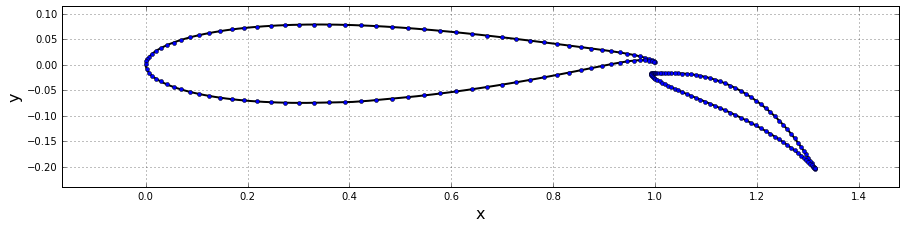

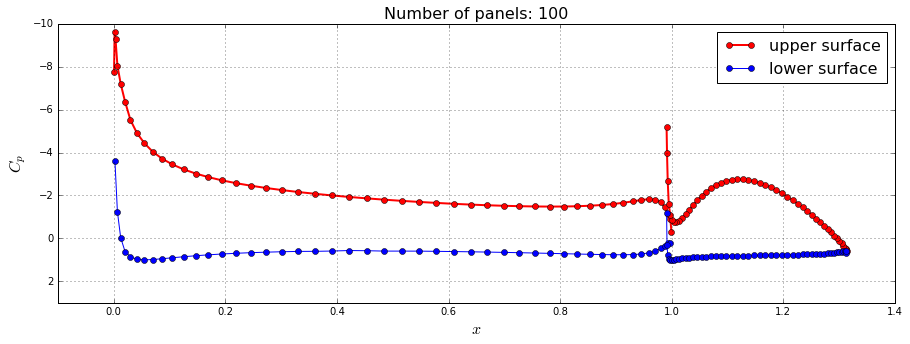

In [129]:
add_a,add_b = ('../AeroPython/lessons/resources/MainFoil_N=100.csv',
         '../AeroPython/lessons/resources/FlapFoil_N=100.csv')

panels_100,lift_100,drag_100 = All(add_a,add_b,0,0,0,0,True)

### Q1.

* What is the pressure coefficient on the $3$<sup>rd</sup> panel on the *main airfoil*?

In [130]:
panels_100[2].cp

-1.1170512527074368

### Q2.

* What is the pressure coefficient on the $10$<sup>th</sup> panel on the *flap airfoil*?

In [131]:
panels_100[100+10-1].cp

-0.28097051323998423

### Q3.

* What is the value of lift?

**Hint:**  $~L = - \oint_{main}p\vec{n}\cdot\vec{j}dl- \oint_{flap}p\vec{n}\cdot\vec{j}dl$

In [132]:
lift_100

3.7083279627856736

### Q4.

* What is the value of drag?  

In [133]:
drag_100

0.0093839099245189503

### Q5.

* Run the program again with 200 panels on both main and flap airfoils. What is the percentage of improvement of the absolute error in the value of lift?

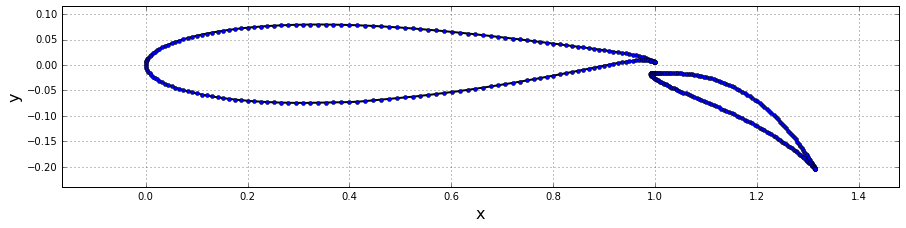

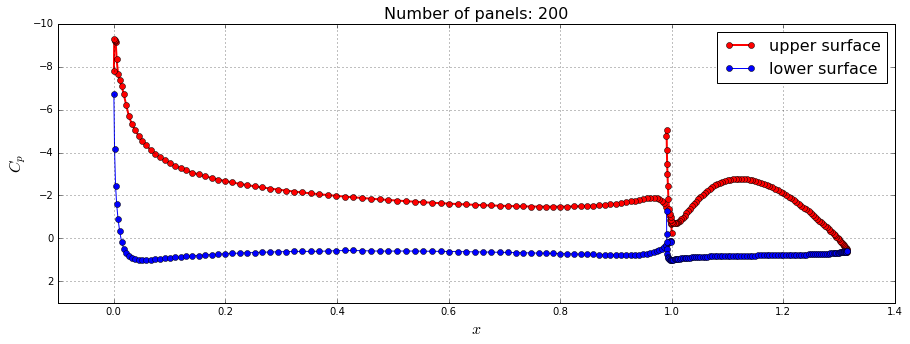

In [134]:
add_a,add_b = ('../AeroPython/lessons/resources/MainFoil_N=200.csv',
         '../AeroPython/lessons/resources/FlapFoil_N=200.csv')
panels_200,lift_200,drag_200 = All(add_a,add_b,0,0,0,0,True)

In [135]:
print("Error with 100 points is ", lift_100 - 3.7386)
print("Error with 200 points is ", lift_200 - 3.7386)
print("The improvement is ", (lift_200 - 3.7386)/(lift_100 - 3.7386))

Error with 100 points is  -0.0302720372143
Error with 200 points is  -0.0159485801921
The improvement is  0.526841985532


# Part 1: Williams' test case

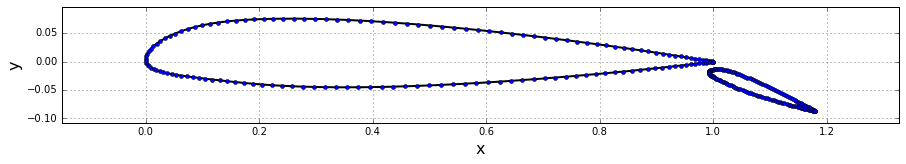

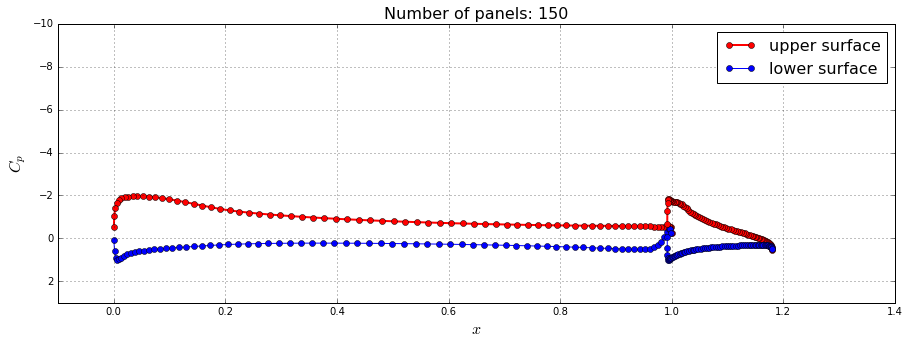

In [136]:
add_a,add_b = ('../AeroPython/lessons/resources/NACA23012_MainFoil.csv',
         '../AeroPython/lessons/resources/NACA23012_FlapFoil.csv')
xc,yc = 1.03,-0.054
panels,lift,drag = All(add_a,add_b,0,20,xc,yc,True)

In [137]:
def bisection_wing(lim_start,lim_end,aof,accu):
    
    # global : add_a, add_b, xc, yc
    
    server_saver = 0
    lift = accu+1

    while server_saver<10 and numpy.abs(lift)>accu :
        server_saver += 1
        aoa = (lim_start+lim_end) /2
        panels,lift,drag = All(add_a,add_b,aoa,aof,xc,yc,False)
        
        if abs(lift)<accu:
            print("")
            print("Zero lift angle of attack:"," Angle of attck =",aoa," ; lift =",lift)
        else:
            print("Round",server_saver," : Angle of attck =",aoa," ; lift =",lift)
        
        if lift > 0:
            lim_end = aoa
        else:
            lim_start = aoa

### Q2.

* Use the [bisection method](http://en.wikipedia.org/wiki/Bisection_method) to determine the angle of attack, $\alpha$, that will cause zero lift when the flap angle is $20$º. Round your answer to the second digit after the floating point.

**HINT**: you can start the bisection method within the range $-14\le\alpha\le14$.

In [138]:
bisection_wing(-14,14,20,0.01)

Round 1  : Angle of attck = 0.0  ; lift = 1.52291823718
Round 2  : Angle of attck = -7.0  ; lift = 0.549047801717
Round 3  : Angle of attck = -10.5  ; lift = 0.0632112168232
Round 4  : Angle of attck = -12.25  ; lift = -0.176253035431
Round 5  : Angle of attck = -11.375  ; lift = -0.0569024694877

Zero lift angle of attack:  Angle of attck = -10.9375  ; lift = 0.00306597092505


In [139]:
def bisection_flap(lim_start,lim_end,aoa,accu):
    
    # global : add_a, add_b, xc, yc
    
    server_saver = 0
    lift = accu+1

    while server_saver<10 and numpy.abs(lift)>accu :
        server_saver += 1
        aof = (lim_start+lim_end) /2
        panels,lift,drag = All(add_a,add_b,aoa,aof,xc,yc,False)
        
        if abs(lift)<accu:
            print("")
            print("Zero lift angle of Flap:"," Angle of flap =",aof," ; lift =",lift)
        else:
            print("Round",server_saver," : Angle of flap =",aof," ; lift =",lift)
        
        if lift > 0:
            lim_end = aof
        else:
            lim_start = aof

### Q2.

* Use the [bisection method](http://en.wikipedia.org/wiki/Bisection_method) to determine the flap angle that will cause zero lift when the angle of attack, $\alpha$, is $0$º. Round your answer to the second digit after the floating point.

In [140]:
bisection_flap(-14,14,0,0.01)

Round 1  : Angle of flap = 0.0  ; lift = 0.272585499251
Round 2  : Angle of flap = -7.0  ; lift = -0.148493260897
Round 3  : Angle of flap = -3.5  ; lift = 0.0609004605127
Round 4  : Angle of flap = -5.25  ; lift = -0.0440869748143

Zero lift angle of Flap:  Angle of flap = -4.375  ; lift = 0.00833465517931


In [141]:
def Q3(Range):
    panels,lift0,drag = All(add_a,add_b,aoa,0,xc,yc,False)
    for i in range(len(Range)):
        panels,lift,drag = All(add_a,add_b,aoa,Range[i],xc,yc,False)
        ratio = (1 - 1/numpy.sqrt(lift/lift0))*100
        print("Slower ratio with flap angle of ",Range[i]," is ",ratio)


### Q3.

* Suppose that the main airfoil is attached to the fuselage of an airplane at an incidence angle of $4$º (that is, the built-in angle of attack of the wing when the airplane is in level flight is $4$º). Compute the lift coefficient with the flap at $0$º deflection, and at $5$, $10$ and $15$ degrees. How much slower (in percentage) can the airplane fly (in level flight) with the flaps extended at these settings, compared with $0$º?

In [142]:
Range = [5,10,15]
aoa = 4
add_a,add_b = ('../AeroPython/lessons/resources/NACA23012_MainFoil.csv',
         '../AeroPython/lessons/resources/NACA23012_FlapFoil.csv')
xc,yc = 1.03,-0.054
Q3(Range)

Slower ratio with flap angle of  5  is  14.5069174021
Slower ratio with flap angle of  10  is  24.2020648575
Slower ratio with flap angle of  15  is  31.2688418592
